In [25]:
# Necesarry imports
import pandas as pd
from sklearn import svm, linear_model
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preparing the model

loading the dataset, extracting the features and learning a support vector machine

In [26]:
df = pd.read_csv("../data/Car.csv");

df.head()

,Unnamed: 0,choice,college,hsg2,coml5,type1,type2,type3,type4,type5,...,pollution3,pollution4,pollution5,pollution6,size1,size2,size3,size4,size5,size6
0,1,choice1,0,0,0,van,regcar,van,stwagon,van,...,0.25,0.25,0.50,0.50,3,3,2,2,3,3
1,2,choice2,1,1,1,regcar,van,regcar,stwagon,regcar,...,0.40,0.40,0.25,0.25,3,3,3,3,2,2
2,3,choice5,0,1,0,regcar,truck,regcar,van,regcar,...,0.40,0.40,0.75,0.75,2,2,3,3,3,3
3,4,choice5,0,0,1,regcar,truck,regcar,van,regcar,...,0.25,0.25,0.60,0.60,2,2,3,3,3,3
4,5,choice5,0,1,0,regcar,truck,regcar,van,regcar,...,0.40,0.40,0.75,0.75,1,1,2,2,3,3


In [27]:
# Utility functions
def extract_choice(choice: str) -> str:
  return choice[-1]

def row_choice(row: pd.Series) -> str:
  return extract_choice(row["choice"])

In [28]:
# Find out Y which is basically the size of each car that was selected
def extract_chosen(row: pd.Series, field: str) -> str | int | float:
  """
    Extracts the chosen answer for a specific field, so that if the row["choice"] is equal to for example 4,
    the row value at "{field}4" would be returned, this is useful for the parsing of a target value 
  """
  choice = row_choice(row)
  return row[f"{field}{choice}"]

def get_target(field: str):
  return df.apply(lambda row: extract_chosen(row, field), axis=1)


In [29]:
# Fuel is categorical and must be converted into corresponding codes
Y_fuel = get_target("fuel").astype("category")
fuel_categories = Y_fuel.cat.categories
Y_fuel = Y_fuel.cat.codes

# The selected size
Y_size = get_target("size").astype("category")
size_categories = Y_size.cat.categories
Y_size = Y_size.cat.codes

In [30]:
# Features

X = df[["college", "hsg2"]].copy(deep=True)
X["price"] = get_target("price")

In [31]:
model_size = svm.SVC(decision_function_shape="ovr")
model_size.fit(X, Y_size)

SVC()

In [32]:
def preferred_size(college, hsg2, price):
  x = np.array([college, hsg2, price]).reshape(1, -1)
  result = model_size.decision_function(x)
  return size_categories[result.argmax()]

In [33]:
Y = df[["hsg2"]]
X = get_target("size")
X_cat = X.astype("category")
X = np.array(X).reshape(-1, 1)

reg = linear_model.LinearRegression().fit(X, Y)
# As you can see the score is not "perfect" but we do find a positive correlation
reg.score(X, Y)

0.014265412376396225

In [36]:
# df
df["hsg2_b"] = df["hsg2"].astype(bool)
df["college_b"] = df["college"].astype(bool)
df["coml5_b"] = df["coml5"].astype(bool)

def assign_target(name: str, ordered = False):
  df[name] = get_target(name).astype("category")
  if (ordered):
    df[name] = df[name].cat.as_ordered()

assign_target("size", ordered=True)
assign_target("type", ordered=True)
assign_target("fuel", ordered=True)

In [35]:
def reg_box_plot(df: pd.DataFrame, x: str, xlabel: str, y: str, ylabel: str):
  palette = sns.light_palette("#786fa6")
  sns.barplot(data=df, x=x, y=y, saturation=1, palette=palette)
  # sns.regplot(data=df, x="type", y=y, scatter=False, color="#786fa6")

  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

  plt.show()


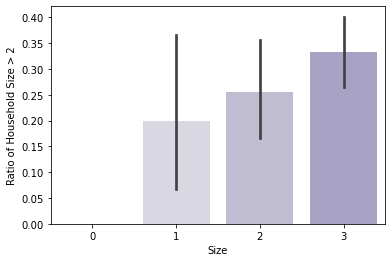

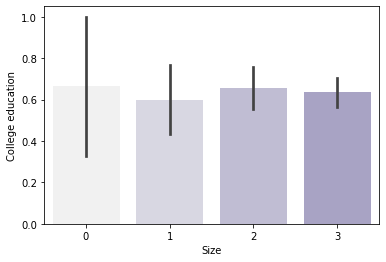

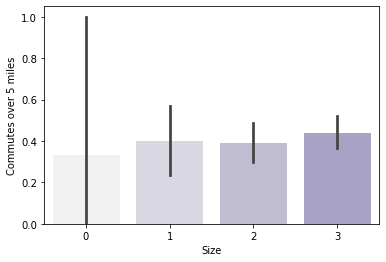

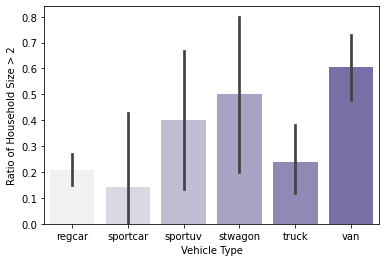

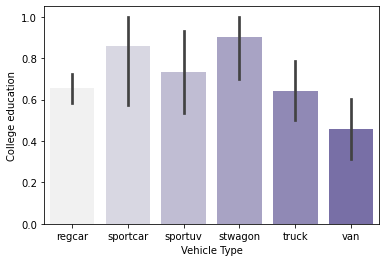

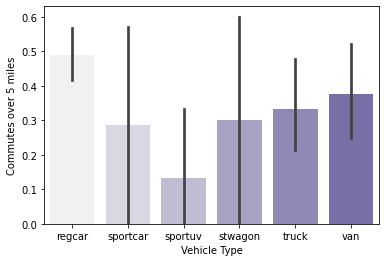

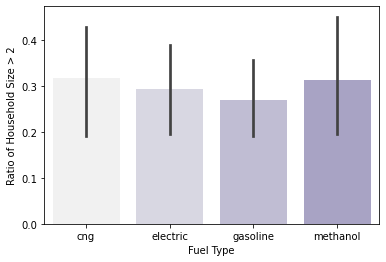

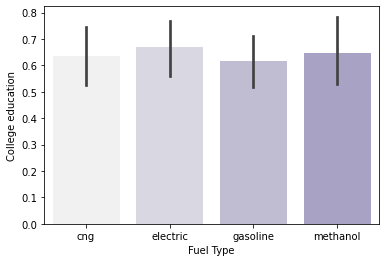

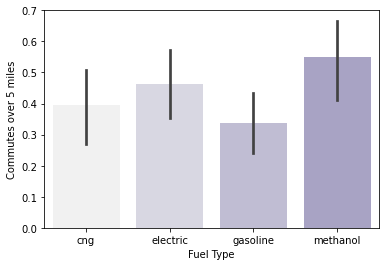

In [42]:
# cat_df = pd.DataFrame({ "hsg2": Y["hsg2"].map(lambda a: a == 1), "size": X_cat.cat.as_ordered()})

Xs = ["size", "type", "fuel"]
X_labels = ["Size", "Vehicle Type", "Fuel Type"]

for (x, xlabel) in zip(Xs, X_labels):
  reg_box_plot(df, x=x, xlabel=xlabel, y="hsg2_b", ylabel="Ratio of Household Size > 2")
  reg_box_plot(df, x=x, xlabel=xlabel, y="college_b", ylabel="College education")
  reg_box_plot(df, x=x, xlabel=xlabel, y="coml5_b", ylabel="Commutes over 5 miles")

In [45]:
size_hsg = df[["size", "hsg2_b"]].groupby("size").mean()
type_hsg = df[["type", "hsg2_b"]].groupby("type").mean()
# size_hsg.loc[[3]]["hsg2_b"][0]
size_hsg, type_hsg

(        hsg2_b
 size          
 0     0.000000
 1     0.200000
 2     0.255556
 3     0.333333,
             hsg2_b
 type              
 regcar    0.207865
 sportcar  0.142857
 sportuv   0.400000
 stwagon   0.500000
 truck     0.238095
 van       0.604167)

In [74]:
from datapoint import dataset
real_df = pd.DataFrame(data=dataset())

In [77]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       10000 non-null  int64 
 1   hhs       10000 non-null  int64 
 2   college   10000 non-null  bool  
 3   decision  10000 non-null  object
dtypes: bool(1), int64(2), object(1)
memory usage: 244.3+ KB


In [88]:
from sklearn.naive_bayes import GaussianNB

X = real_df[["age","hhs", "college"]].values
Y = real_df["decision"]

clf = GaussianNB()
clf.fit(X, Y)
clf_classes = clf.classes_

In [129]:
def predict(age, hhs, college, alpha) -> str:

  p = clf.predict_proba([[age, hhs, college]])[0]
  max_p = p.max()

  print(p)

  choices = filter(lambda a: p[a[0]] >= max_p - alpha, enumerate(clf_classes))
  choices = map(lambda a: a[1], choices)

  return np.random.choice(list(choices))

In [130]:
clf.classes_

array(['L', 'M', 'S', 'XS'], dtype='<U2')

In [183]:
predict(43, 3, False, 0.2)

[0.28566228 0.30961059 0.22609221 0.17863492]


'S'

In [116]:
# Simulation

0
1
2
3


[]

In [1]:
final_df = pd.read_csv("../data/final_dataset.csv")

NameError: name 'pd' is not defined

In [188]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2636186 entries, 0 to 2636185
Columns: 138 entries, id to provider_fleetsize_weekly
dtypes: bool(3), float64(94), int64(16), object(25)
memory usage: 2.7+ GB


In [200]:
pd.set_option("display.max_columns", None)
car_df = final_df[final_df["vehicleType"] == "car"]

In [212]:
car_df

,id,provider,city,vehicleType,model,datetime_start,date_start,time_start,datetime_end,date_end,time_end,longitude_start,latitude_start,longitude_end,latitude_end,fuel_start,fuel_end,distance,duration,price_driving_start,price_driving_end,price_promo_start,price_promo_end,idle_duration,geometry,missing_file_number,h3_9,tier,emio,callabike,bmw 2er active tourer,bmw 2er cabrio,bmw x2,mercedes-benz gla,bmw x1,mercedes-benz a-klasse,mini 3-tuerer,mini 5-tuerer,mini cabrio,mini clubman,mini countryman,mercedes-benz b-klasse,bmw i3,smart fortwo 3rd generation,bmw 1er,nextbike,low quality vehicle,medium quality vehicle,premium quality vehicle,month,dayofweek,time_bucket,weekend,week,is_holiday,sharenow_postmerger,hex_start,hex_end,elevation_change,ascent,descent,start_d2c,end_d2c,d2c_change,d2c_direction,orig_clc,dest_clc,orig_level_1,orig_level_2,orig_level_3,dest_level_1,dest_level_2,dest_level_3,Bezirk,Bevölkerung,Alter unter 15,Alter 15 – 45,Alter 45 – 65,Alter 65 und mehr,Erwerbspersonen / Erwerbstätige,Erwerbspersonen / Erwerbslose,Nicht erwerbspersonen,Bevölkerung / Monatliches Nettoeinkommen unter 900,Bevölkerung / Monatliches Nettoeinkommen 900 – 1500,Bevölkerung / Monatliches Nettoeinkommen 1500 und mehr,Erwerbstätige / Monatliches Nettoeinkommen unter 900,Erwerbstätige / Monatliches Nettoeinkommen 900 – 1500,Erwerbstätige / Monatliches Nettoeinkommen 1500 und mehr,Rechtliche Einheiten,Sozialversicherungspflichtig Beschäftigte 2018,Umsatz 2018 (EUR),Studierende 2019,Bevölkerung mit Migrationshintergrund 2018,Ledig,Verheiratet,Geschieden,Verwitwet,Eingetr. Lebenspartnerschaft,Ohne Angabe,Eingetr. Lebenspartnerschaft aufgehoben,Eingetr. Lebenspartner/-in verstorben,Unter 18,30 - 49,65 und älter,18 - 29,50 - 64,Einheiten insgesamt,total_households,Einpersonenhaushalte (Singlehaushalte),Paare ohne Kind(er),Alleinerziehende Elternteile,Paare mit Kind(ern),Mehrpersonenhaushalte ohne Kernfamilie,temp,precipitation,shopping_start,shopping_end,food_start,food_end,health_start,health_end,transport_start,transport_end,services_start,services_end,outdoor_start,outdoor_end,leisure_and_entertainment_start,leisure_and_entertainment_end,civil_services_start,civil_services_end,h3_8,h3_7,discrete_count_9,discrete_count_8,discrete_count_7,provider_merged,provider_fleetsize_weekly
303541,ZnJlZWZsb2F0OjpjYXIyZ286OldCQTFSNTEwMDA1SzU2MjU2,car2go,berlin,car,BMW 1er,2020-01-17 11:48:08+01:00,20200117,1145,2020-01-17 12:18:08+01:00,20200117,1215,13.333420,52.527400,13.305150,52.499580,34.0,28.0,3637.190728,1800.0,NaN,NaN,NaN,NaN,2400.0,POINT (13.33342 52.5274),1.0,617540519153369087,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1,4,"[800, 1200)",False,3,False,True,891f1d48e8bffff,891f1d49c27ffff,1.050077,48.753005,47.702928,5492.121655,6596.567931,1104.446276,outbound,111,111,Artificial surfaces,Urban fabric,Continuous urban fabric,Artificial surfaces,Urban fabric,Continuous urban fabric,Mitte,372347.8,46293.2,198591.4,83948.4,43514.8,204400.0,16500.0,151400.0,89000.0,86800.0,147000.0,24900.0,52500.0,126700.0,26768.0,428283.0,100409306.0,37372.752,182200.0,212.0,54.0,19.0,5.0,3.0,0.0,3.0,0.0,23.0,87.0,25.0,114.0,45.0,294.0,212.0,151.0,28.0,9.0,12.0,12.0,7.8,False,360412.149593,566477.500999,476961.665886,548257.946739,331675.228236,381682.270991,158890.936322,231353.792340,402892.254925,862487.405692,220217.309792,124221.194049,131226.330918,187638.143837,216985.292350,166618.711053,613036919527309311,608533319906230271,2,10,50,sharenow,2761
303542,ZnJlZWZsb2F0OjpjYXIyZ286OldCQTFSNTEwMDA1SzU2MjU2,car2go,berlin,car,BMW 1er,2020-01-17 12:18:08+01:00,20200117,1215,2020-01-17 13:03:26+01:00,20200117,1300,13.305150,52.499580,13.346880,52.549530,28.0,28.0,6230.522471,2718.0,NaN,NaN,NaN,NaN,0.0,POINT (13.30515 52.49958),1.0,617540519381696511,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,0.0,1,4,"[1200, 1600)",False,3,False,True,891f1d49c27ffff,891f1d48c93ffff,-0.827583,65.97080